# Analyze Merfish data

Apply Squidpy for the analysis of Merfish data, obtained from [Mofitt et al. 2018](https://www.science.org/doi/10.1126/science.aau5324). A pre-processed subset of the data is provided in `anndata.AnnData` format.

## Import packages & data

In [14]:
import scanpy as sc
import squidpy as sq

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

sc.logging.print_header()
print(f"squidpy=={sq.__version__}")

# load the pre-processed dataset
adata = sq.datasets.merfish()
adata

scanpy==1.9.6 anndata==0.10.3 umap==0.5.5 numpy==1.26.2 scipy==1.11.4 pandas==2.1.3 scikit-learn==1.3.2 statsmodels==0.14.0 igraph==0.11.3 louvain==0.8.1 pynndescent==0.5.11
squidpy==1.2.2


AnnData object with n_obs × n_vars = 73655 × 161
    obs: 'Cell_ID', 'Animal_ID', 'Animal_sex', 'Behavior', 'Bregma', 'Centroid_X', 'Centroid_Y', 'Cell_class', 'Neuron_cluster_ID', 'batch'
    uns: 'Cell_class_colors'
    obsm: 'spatial', 'spatial3d'

This datasets consists of consecutive slices from the mouse hypothalamic preoptic region. It represents an interesting example of how to work with 3D spatial data in Squidpy. Visualize the 3D stack of slides using `scanpy.pl.embedding()`.

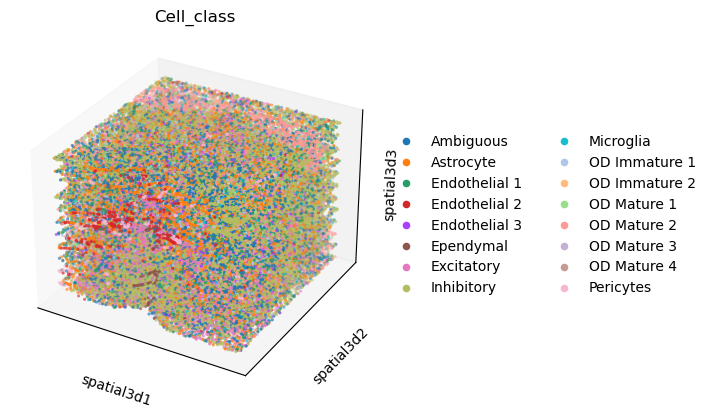

In [15]:
sc.pl.embedding(adata, basis="spatial3d", projection="3d", color="Cell_class")

Or visualize a single slide with `squidpy.pl.spatial_scatter()`. The slide identifier is stored in `adata.obs["Bregma"]`.

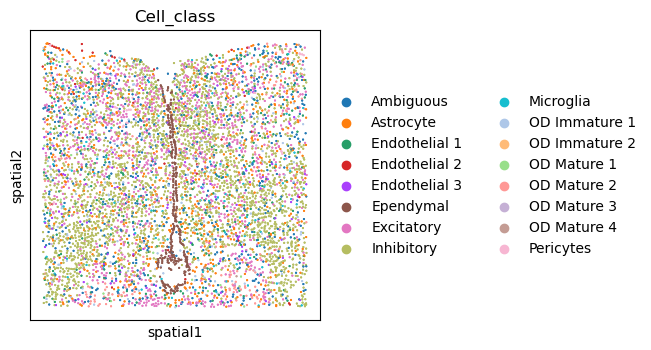

In [16]:
sq.pl.spatial_scatter(
    adata[adata.obs.Bregma == -9], shape=None, color="Cell_class", size=1
)

## Neighborhood enrichment analysis in 3D

It is important to consider whether the analysis should be performed on the 3D spatial coordinates or the 2D coordinates for a single slice. Functions that make use of the spatial graph can already support 3D coordinates, but it is important to consider that the z-stack coordinate is in the same unit metrics as the x, y coordinates. Starting with the neighborhood enrichment score, compute a neighborhood graph with `squidpy.gr.spatial_neighbors()`. To compute the neighbor graph on the 3D coordinate space, specify `spatial_key = "spatial3d"`. Then use `squidpy.gr.nhood_enrichment()` to compute the score, and visualize it with `squidpy.gr.nhood_enrichment()`.

  0%|          | 0/1000 [00:00<?, ?/s]

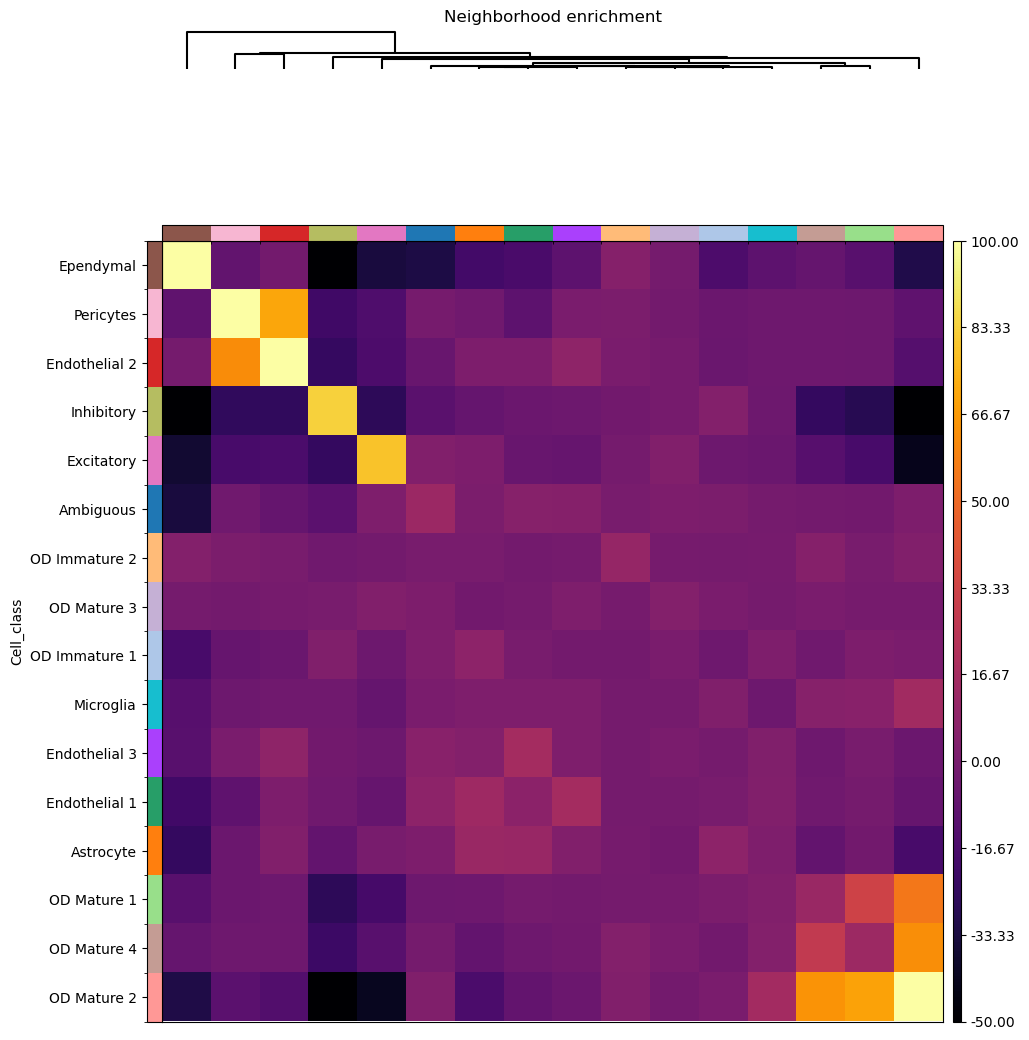

In [17]:
sq.gr.spatial_neighbors(adata, coord_type="generic", spatial_key="spatial3d")
sq.gr.nhood_enrichment(adata, cluster_key="Cell_class")
sq.pl.nhood_enrichment(
    adata, cluster_key="Cell_class", method="single", cmap="inferno", vmin=-50, vmax=100
)

Visualize some of the co-enriched clusters with `scanpy.pl.embedding()`. We will set `na_colors=(1,1,1,0)` to make transparent the other observations, in order to better visualize the clusters of interests across z-stacks.

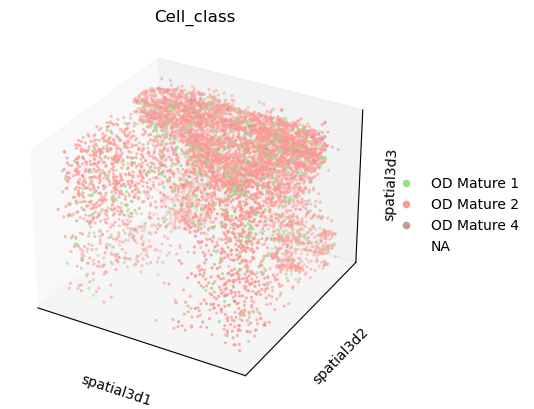

In [18]:
sc.pl.embedding(
    adata,
    basis="spatial3d",
    groups=["OD Mature 1", "OD Mature 2", "OD Mature 4"],
    na_color=(1, 1, 1, 0),
    projection="3d",
    color="Cell_class",
)

Visualize gene expression in 3D coordinates. Perform diffrential expression testing with `scanpy.tl.rank_genes_groups()` and visualize the results.

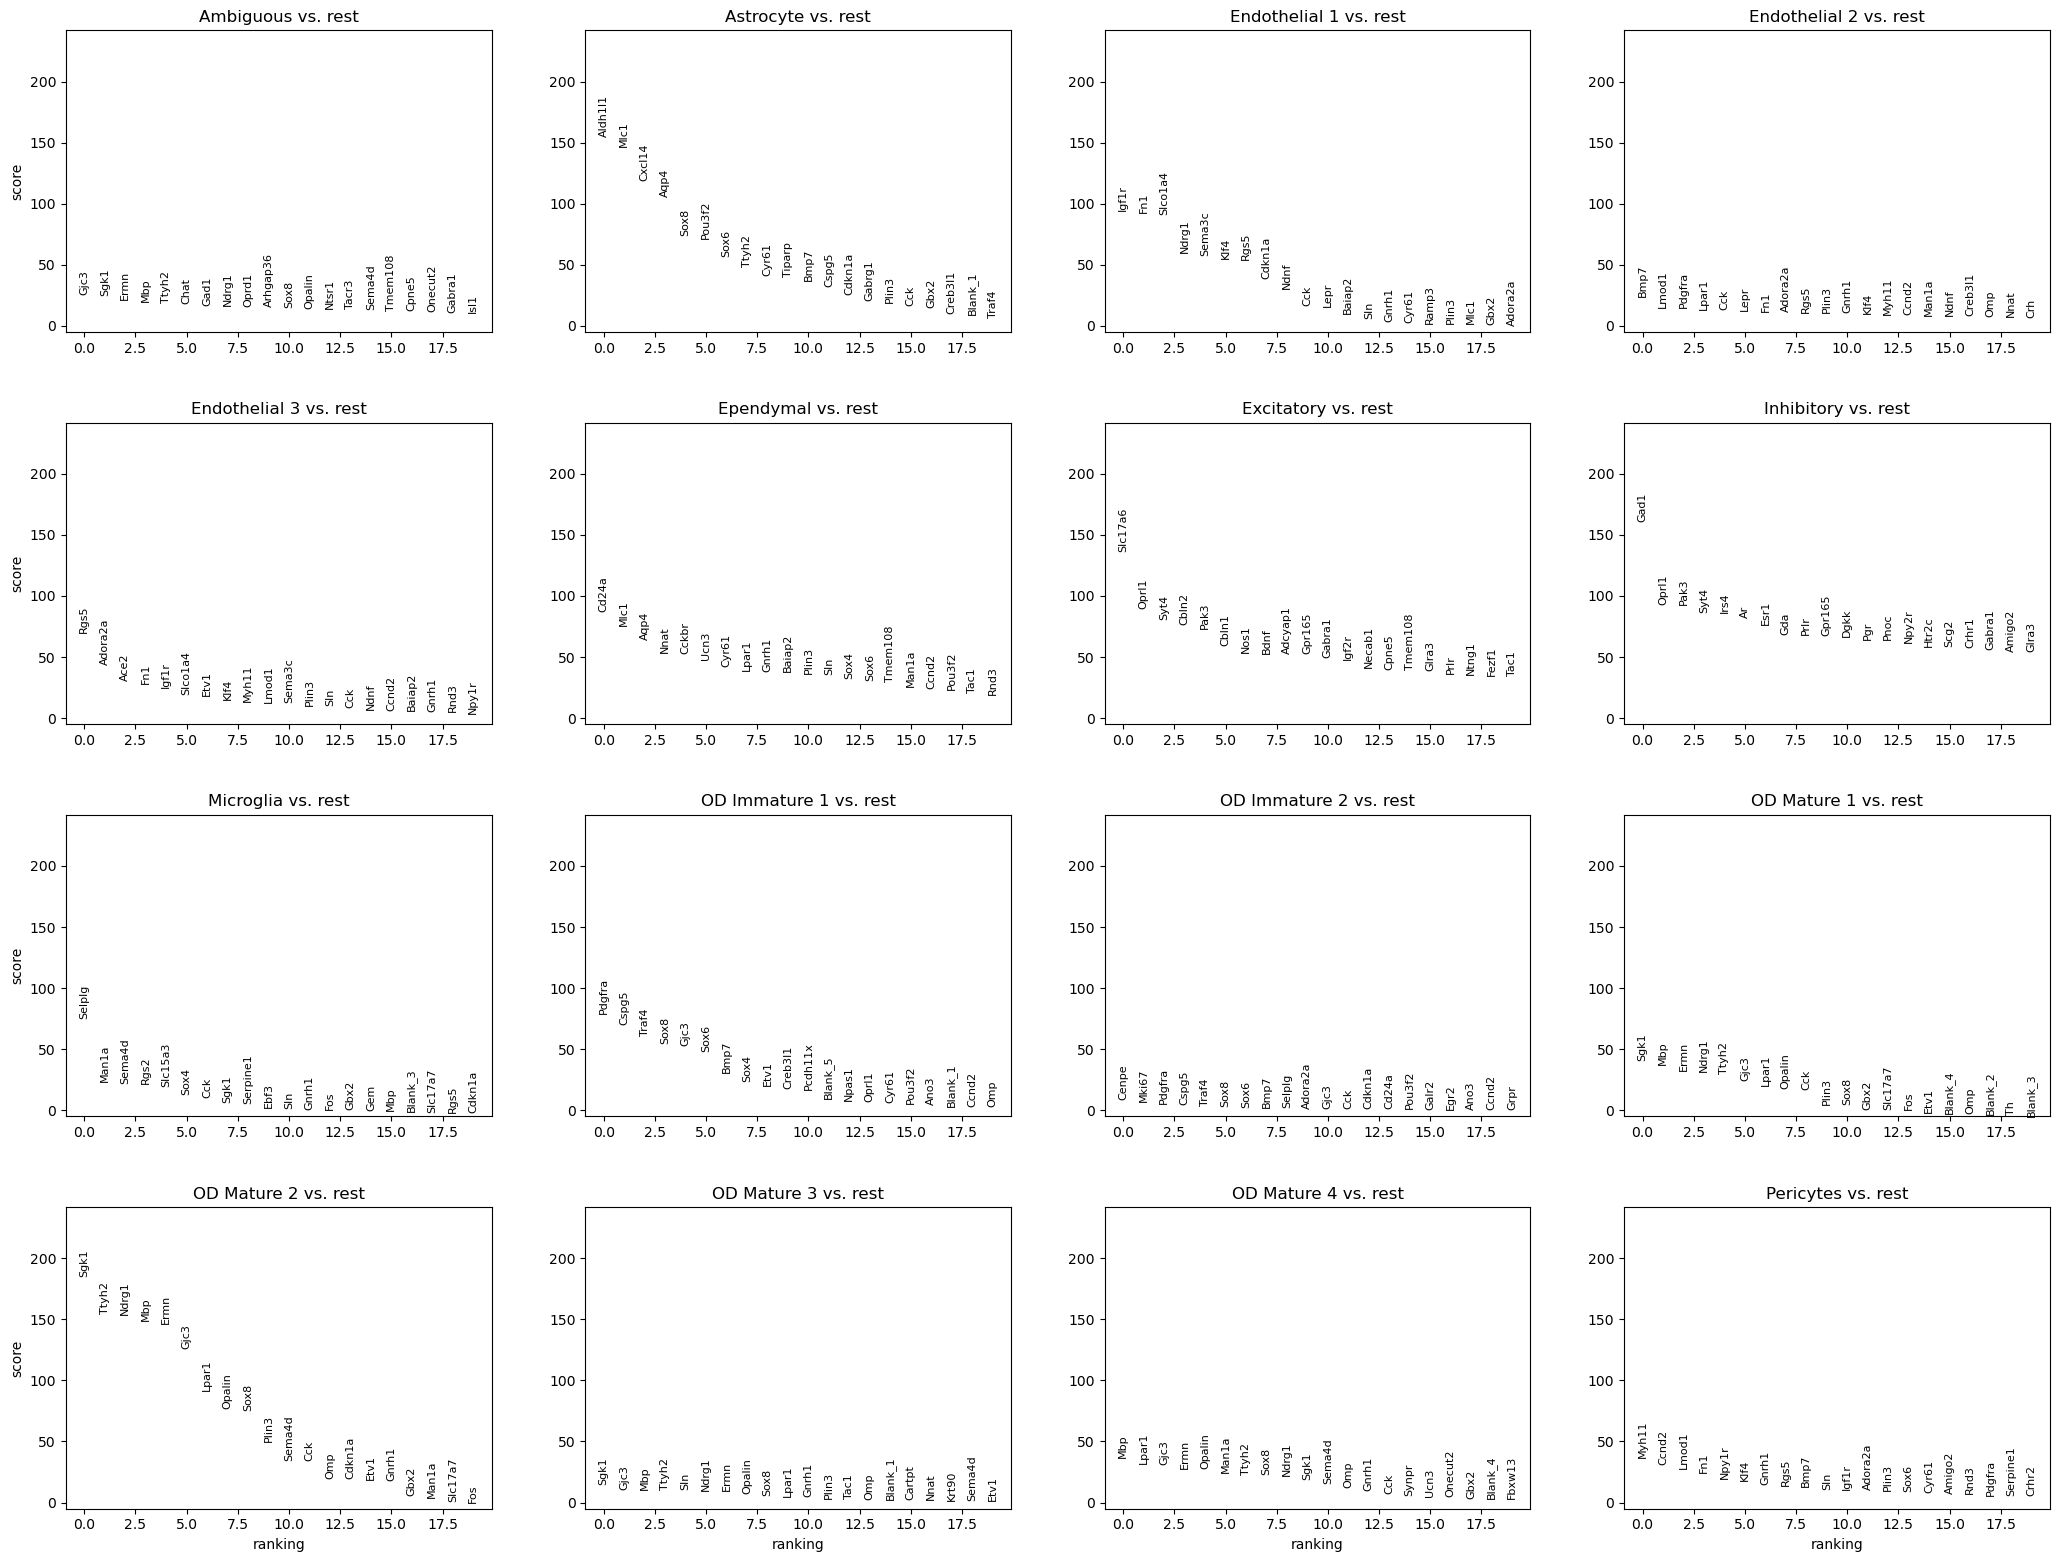

In [19]:
sc.tl.rank_genes_groups(adata, groupby="Cell_class")
sc.pl.rank_genes_groups(adata, groupby="Cell_class")

And the expression in 3D.

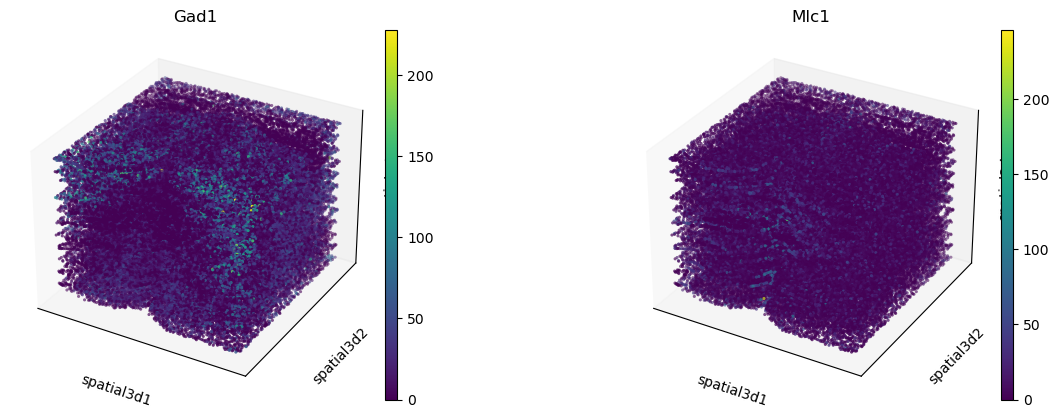

In [20]:
sc.pl.embedding(adata, basis="spatial3d", projection="3d", color=["Gad1", "Mlc1"])

If the same analysis should be performed on a single slice, then it is advisable to copy the sample of interest in a new `anndata.AnnData` and use it as a standard 2D spatial data object.

  0%|          | 0/1000 [00:00<?, ?/s]

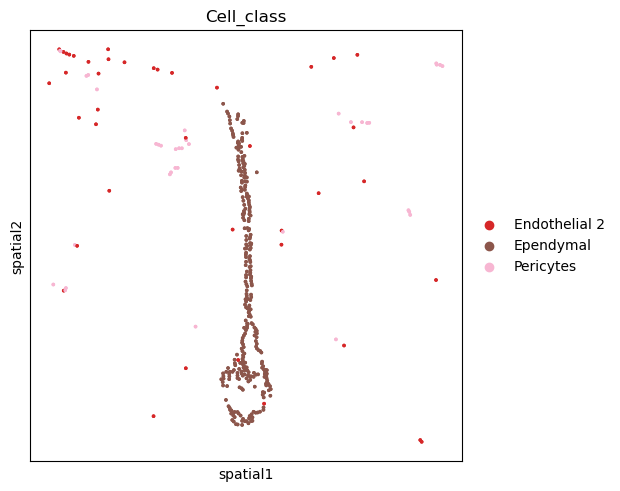

In [21]:
adata_slice = adata[adata.obs.Bregma == -9].copy()
sq.gr.spatial_neighbors(adata_slice, coord_type="generic")
sq.gr.nhood_enrichment(adata, cluster_key="Cell_class")
sq.pl.spatial_scatter(
    adata_slice,
    color="Cell_class",
    shape=None,
    groups=[
        "Ependymal",
        "Pericytes",
        "Endothelial 2",
    ],
    size=10,
)

## Spatially variable genes with spatial autocorrelation statistics

Investigate spatial variability of gene expression. `squidpy.gr.spatial_autocorr()` wraps two spatial autocorrelation statistics: _Moran's I_ and _Geary's C_. They provide a score on the degree of spatial variabilty of gene expression. The statistics as well as the p-value are computed for each gene, and FDR correction is performed. The results are stored in `adata.uns['moranI']` and we can visualize selected genes with `squidpy.pl.spatial_scatter()`. 

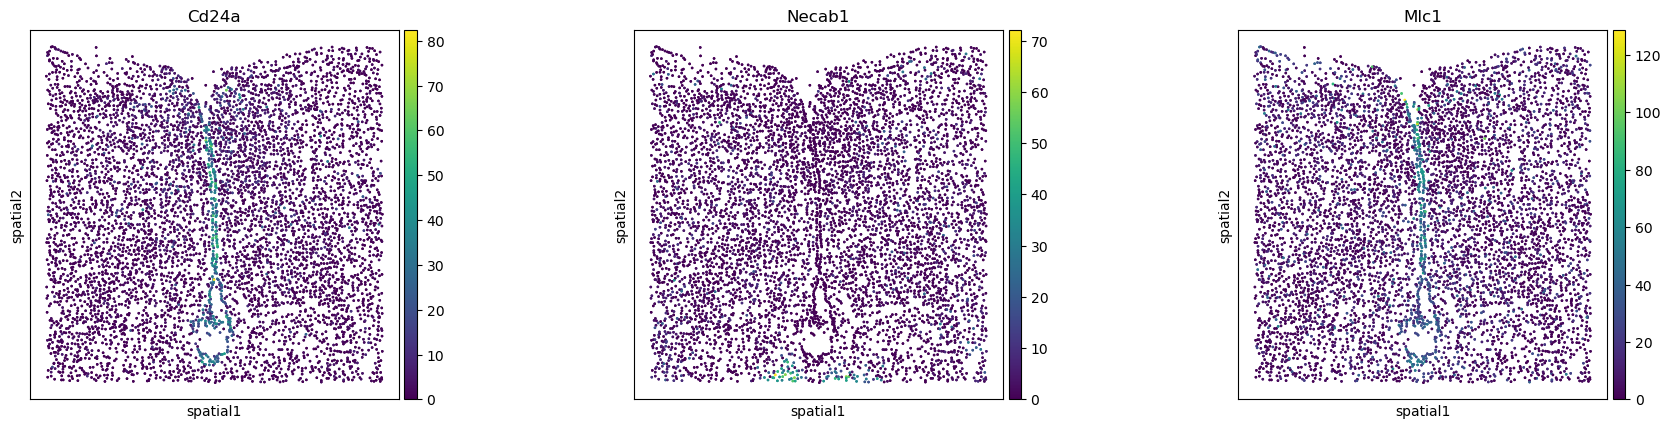

In [22]:
sq.gr.spatial_autocorr(adata_slice, mode="moran")
adata_slice.uns["moranI"].head()
sq.pl.spatial_scatter(
    adata_slice, shape=None, color=["Cd24a", "Necab1", "Mlc1"], size=3
)